# Лабораторная работа №2

## Цель работы 

Знакомство и освоение работы с дополнительными методами машинного обучения для решения задачи регрессии библиотеки sklearn.

# Подключение библиотек

In [443]:
# Python 3.11
import pandas as pd
import numpy  as np

from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns

In [444]:
import sklearn
print("Версия scikit-learn: {}".format(sklearn.__version__))
print("Версия pandas: {}".format(pd.__version__))
print("Версия numpy: {}".format(np.__version__))

Версия scikit-learn: 1.1.2
Версия pandas: 1.4.4
Версия numpy: 1.21.3


# Объявление функций

Для повышения повторяемости кода и повышения уровня читаемости объявим несколько функций с уже знакомыми операциями

In [445]:
def PLOT34(y_test, y_pred):
    '''
    Функция построения графиков
    :param y_test: - проверочные значения целевой переменный
    :param y_pred: - вычисленные значения целевой переменный
    '''
    plt.figure(figsize=(12,6))
    
    # == Диаграмма рассеяния вычисленных значений ==
    # Создать первое полотно 121: 1-строк, 2-столбцов, 1-индекс текущего полотна в сетке
    plt.subplot(121)
    plt.scatter(y_test, y_pred,  alpha=0.1)
    plt.scatter(y_test, y_test,  alpha=0.1)
    plt.title('Диаграмма рассеяния вычисленных значений');
    plt.xlabel('Проверочное Y')
    plt.ylabel('Вычисленное Y')

    
    # == Диаграмма рассеяния ошибок ==
    # Создать первое полотно 121: 1-строк, 2-столбцов, 2-индекс текущего полотна в сетке
    plt.subplot(122)
    plt.scatter(y_test, (y_test - y_pred)**2,  alpha=0.1)
    plt.title('Диаграмма рассеяния ошибок')
    plt.xlabel('Проверочное Y')
    plt.ylabel('Абсолютная ошибка')

In [446]:
def GET_METRICS_SINGLE(y_test, y_pred):
    '''
    Вычисление и вывод метрик: MAE, RMSE, R2, где:
    :MAE    - средняя абсолютная ошибка
    :RMSE   - средне-квадратичная ошибка
    :R2     - коэффициент определённости
    На основе сравнения проверочных и вычисленных.
    :param y_test: - проверочные значения целевой переменный
    :param y_pred: - вычисленные значения целевой переменный
    '''
    mae  = metrics.mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    r2   = metrics.r2_score(y_test, y_pred)

    return (mae, rmse, r2)

In [447]:
def PRINT_METRICS(metrics):
    '''
    Печатает метрики, вычисленные функцией 'GET_METRICS_SINGLE'
    '''
    mae, rmse, r2 = metrics

    print("MAE - средняя абсолютная ошибка: {:>7,.3f}".format(mae))
    print("RMSE - кв. корень из среднеквадратичной ошибки: {:>7,.3f}".format(rmse))
    print("R2 - коэфф. детерминации:        {:>7,.3f}".format(r2))


# Загрузка подготовленных данных

Загрузим набор подготовленных в первой работе данных. В данном наборе исключены  
пустые значения и выбросы:

In [448]:
df = pd.read_csv('../datasets/ccpp_nan_PREPARED.csv', # путь к файлу
                   sep=';',     # разделитель данных в файле
                   header=0,    # номер строки с заголовками
)
print("Размер таблицы", df.shape)
df[:2]

Размер таблицы (9376, 5)


,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75


Для начала определим точный список признаков с целевой и независимыми признаками,  
а после оставим в таблице только перечисленные столбцы. Поскольку в предыдущей  
работе наименьшие показатели ошибок MAE и RMSE и наибольший коэффициент  
детерминации R2 был у модели со всеми четырьмя показателями окружающей среды, т.н:  
AT, V, AP и RH, то возьмём их все в качестве независимых признаков. Целевым  
признаком у нас будет объём выработки электроэнергии PE:

In [449]:
features = ['AT', 'V', 'AP',  'RH']
target   = ['PE']

In [450]:
df = df[features+ target]
df[:2]

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75


# Приведение к новой шкале значений

Важнейшими числовыми характеристиками случайной величины являются:

- Математическое ожидание, имеющее смысл среднего значения  (mean)  $ {\\mu} $ (мю) - центр распределения случайной величины: .mean()
      
- Среднеквадратическое отклонение (Standard_deviation) $ {\\sigma} $ (сигма) - показатель рассеивания относительно её мат. ожидания: .std()
      
- Дисперсия (Variance) $ {\\var = sigma^2} $ (сигма в квадрате) - мера разброса относительно её мат. ожидания:  
.var = .std()**2


Некоторые методы машинного обучения 
сильно чувствительны к шкалированию данных. 

При подготовки данных чаще всего выполняются процедуры: 

- либо __нормализации__  -  приведения значений к диапазону от 0.0 до 1.0 Пример:
      
      |--------------|+++++++++|----|
      |--------------|++++++++++++++|
      0             1900     1970  2000
      
      Обрабатываемое: 1970
      Макс. значение: 1900
      Мин. значение:  2000
      
      Процедура нормализации:
      x_norm = ( x - X.min() ) / ( X.max() -  X.min() )
      x_norm = ( 1970 - 1900 ) / (2000 - 1900)
      x_norm = 70 / 100
      x_norm = 0.70
      
      Восстановление:
      x = ( x_norm * ( X.max() -  X.min() ) +  X.min()
      x = ( 0.70 * (2000 - 1900) + 1900
      x = ( 0.70 * 100) + 1900
      x = 70 + 1900
      x = 1970



- либо __стандартизации__ - предобработки данных, после которой каждый признак имеет среднее (mean) = 0 и дисперсию (variance) = 1. Стандартизовать - вычесть среднее и поделить на стандартное отклонение. Критично для линейных моделей.
      X_stantartised = (X - X.mean()) / X.std()

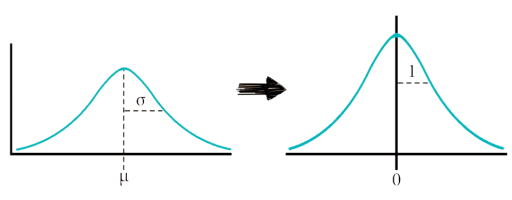
<p style="text-align: left;"> Рисунок 1. Вид гистограмм до и после стандартизации </p>

"Одно из наиболее важных допущений при работе с линейными моделями, параметры которых оцениваются методом наименьших квадратов, состоит в том, что остатки модели независимы (т.е. не коррелируют) и имеют нормальное распределение со средним значением 0 и некоторым фиксированным стандартным отклонением"

Среднекв. откл. (Stand._dev.) 24.166091947189145
Дисперсия (Variance)  584.0
Средрее (Mean) 1956.0


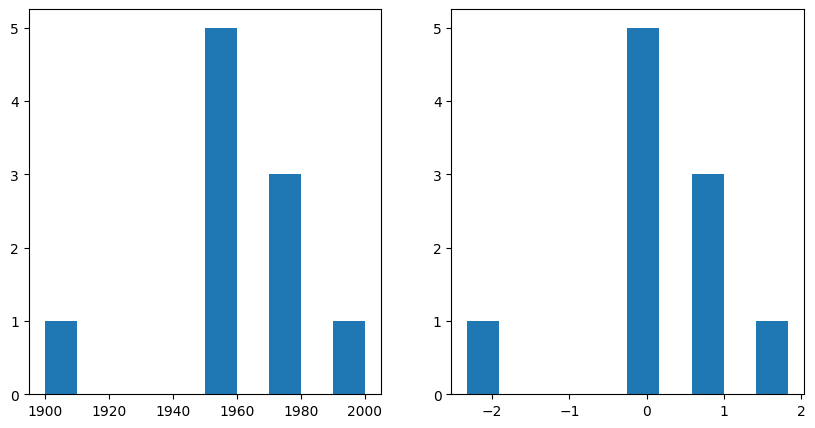

In [451]:
# Пример операции стандартизации
df_ex1 = pd.DataFrame(np.array([
    1900, 1950,1950,1950,1950,1950,1970,1970,1970, 2000 # последовательность
]))
print("Среднекв. откл. (Stand._dev.)", df_ex1.std(ddof=0)[0])
print("Дисперсия (Variance) ", df_ex1.var(ddof=0)[0])
print("Средрее (Mean)", df_ex1.mean()[0])

# X_stantartised = (X - X.mean()) / X.std()
df_Std = (df_ex1 - df_ex1.mean())/df_ex1.std(ddof=0)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist(df_ex1)  # в google colab следует использовать df_ex1.values
plt.subplot(122)
plt.hist(df_Std); # в google colab следует использовать df_Std.values

Для дальнейшей работы рассмотрим способы выполнения операции стандартизации

## Стандартизация. Способ №1

Благодаря наличию функций вычисления статистических характеристик в библиотеке pandas, стандартизацию можно выполнить прямом вычислением:

In [452]:
df_scaled = (df - df.mean()) / df.std(ddof=0) # обязательный параметр ddof=0
df_scaled[:2]

,AT,V,AP,RH,PE
0,-1.530142,-1.073020,-0.402510,1.145758,1.540583
1,0.529063,0.321203,-0.304605,0.060573,-0.498168


## Стандартизация. Способ №2.

В библиотеке sklearn, для выполнения процедуры стандартизации, присутствует более удобный класс __sklearn.preprocessing.StandardScaler__, который содержит методы:

- __StandardScaler.fit(  X  )__ - вычисление значений __среднего__ и __дисперсии__

- __StandardScaler.transform( X )__ - прямого преобразования из истинного значения к приведенному

- __StandardScaler.inverse_transform( X )__ - обратного преобразования из приведенного значения в истинное

In [453]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [454]:
# Вычисление значений среднего и дисперсии отдельно для каждого признака
scaler.fit(df)

StandardScaler()

In [455]:
print (" {:>3} {:<25} {:>16} {:>16}".format(
 "№", "Признак", "Средрее", "Ср.кв.откл."
))
for icol in range (0, len(df.columns)):
    print(" {:>3} {:<25} {:>16.3f} {:>16.3f}".format(
                icol, 
                df.columns[icol],
                scaler.mean_[icol],
                np.sqrt ( scaler.var_[icol]), # кв. корень (из дисперсии)
            )
        )

   № Признак                            Средрее      Ср.кв.откл.
   0 AT                                  19.709            7.430
   1 V                                   54.408           12.710
   2 AP                                1013.142            5.720
   3 RH                                  73.318           14.569
   4 PE                                 454.236           17.035


При прямом преобразовании значений (функция transform()) данные возвращаются без информации о принадлежности к строкам и столбцам.

In [456]:
scaler.transform(df)

array([[-1.5301417 , -1.07301975, -0.4025097 ,  1.14575792,  1.54058267],
       [ 0.52906265,  0.32120329, -0.30460477,  0.06057337, -0.49816806],
       [ 1.35005262,  0.19610088, -1.04763328, -2.15578394, -0.90850113],
       ...,
       [-0.50053953, -0.8708102 ,  0.1849199 ,  0.36670386,  0.68821698],
       [-0.27712259,  0.42978273,  0.95067634,  1.46424345, -0.19408718],
       [ 0.53444619, -0.24451136, -0.22418286, -0.14259844, -0.15064706]])

Для удобства восприятия сформируем новую таблицу (DataFrame) с указанием названий признаков и идентификаторов строк, соответствующих таблице-оригиналу. Сравните значения с таблице в п. 5.1.

In [457]:
# создать новую таблицу (DataFrame) 
# со стандартизированными значениями

df_scaled = pd.DataFrame(
    data    = scaler.transform(df), # значения ячеек    <<--
    columns = df.columns,           # названия столбцов
    index   = df.index              # идентификаторы строк
)
df_scaled[:2]

,AT,V,AP,RH,PE
0,-1.530142,-1.073020,-0.402510,1.145758,1.540583
1,0.529063,0.321203,-0.304605,0.060573,-0.498168


Используя класс  __sklearn.preprocessing.StandardScaler__ становится доступна операция обратного предобразования к исходным НЕ стандартизированным значениям. Этот прием пригодится позже при работе с обученной моделью.

In [458]:
# строка в стандартизированном виде
df_scaled[0:1]

,AT,V,AP,RH,PE
0,-1.530142,-1.07302,-0.40251,1.145758,1.540583


In [459]:
# Результат обратного преобразования обернутые в таблицу (DataFrame) 
pd.DataFrame(
    data = scaler.inverse_transform(df_scaled [0:1]),
    columns = df.columns
)

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48


Посмотри исходные значения и сравним с восстанлвлеными 

In [460]:
df[0:1]

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48


## Информация по целевой переменной
Получим величину среднего значения и дисперсии для целевой переменной:

In [461]:
print("Статические характеристики целевой переменной PE:")
print("Средрее значение:", df.mean()[4])
print("Дисперсия: ", df.var(ddof=0)[4])

Статические характеристики целевой переменной PE:
Средрее значение: 454.2362638651877
Дисперсия:  290.1892424086175


Затем построим гистограммы распределения исходных и стандартизированных значений  
для целевого признака:

Text(0.5, 0, "Стандартизованное значение 'PE'")

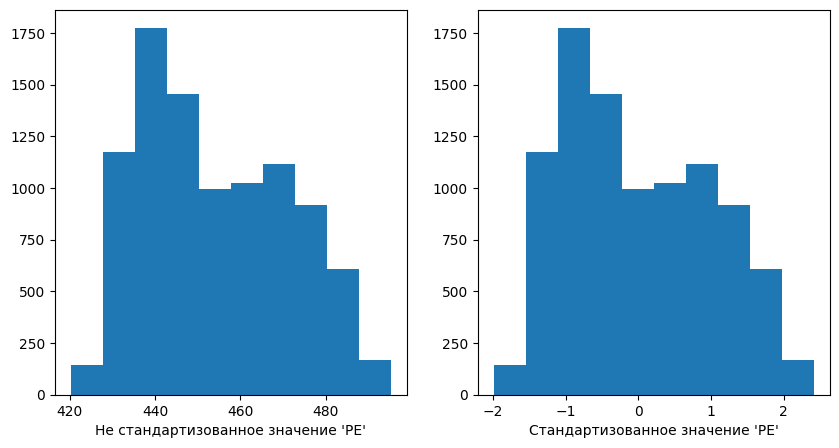

In [462]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist(df.loc[:, 'PE'].values)
plt.xlabel("Не стандартизованное значение 'PE'")
plt.subplot(122)
plt.hist(df_scaled.loc[:, 'PE'].values)
plt.xlabel("Стандартизованное значение 'PE'")

# Формирование тренировочной и проверочной выборок

In [463]:
valid_size = 0.3    # доля тестовой части в выборке
rand_seed = 42      # начальное состояние генератора случ. чисел

##  НЕ Стандартизованные

In [464]:
x_train, x_test, y_train, y_test = train_test_split(
    df[features],    # исходные данные X
    df[target],      # исходные данные y
    
    test_size = valid_size, # доля тестовой части в выборке
    random_state=rand_seed, # начальное состояние генератора случ. чисел
    shuffle=True            # перемешивание
) 

y_train = y_train['PE']
y_test = y_test['PE']

x_train[:2]

,AT,V,AP,RH
5523,20.54,68.12,1012.23,81.06
9338,29.75,73.50,1011.13,67.31


In [465]:
y_train[:2]

5523    440.28
9338    433.63
Name: PE, dtype: float64

In [466]:
print ("Кол-во элементов: \n  x_train: {}, y_train {} \n  x_test:  {}, y_test  {} \n  total x: {}, total y {} ".format  (
    len(x_train), len(y_train),
    len(x_test),  len(x_test), 
    len(x_train)+len(x_test), len(y_train)+len(x_test),
))

Кол-во элементов: 
  x_train: 6563, y_train 6563 
  x_test:  2813, y_test  2813 
  total x: 9376, total y 9376 


## Стандартизованные

In [467]:
xStd_train, xStd_test, yStd_train, yStd_test =  train_test_split(
    df_scaled[features],    # исходные данные X
    df_scaled[target],      # исходные данные y
    
    test_size = valid_size, # доля тестовой части в выборке
    random_state=rand_seed, # начальное состояние генератора случ. чисел
    shuffle=True            # перемешивание
) 

yStd_train = yStd_train['PE']
yStd_test = yStd_test['PE']


xStd_train[:2]

,AT,V,AP,RH
5523,0.111838,1.078899,-0.159496,0.531438
9338,1.351399,1.502201,-0.351809,-0.412350


In [468]:
yStd_train[:2]

5523   -0.819273
9338   -1.209647
Name: PE, dtype: float64

# Проверка влияния стандартизации

Для исследования влияния процесса стандартизации используем новый тип модели - __linear_model.SGDRegressor__. Особенности внутреннего устройства рассматривать пока не будем.

В библиотеке sklearn большинство методов обладают единым интерфейсом взаимодействия и содержат методы
```
- model.fit(x_train, y_train) - обучение модели, вычисление коэфф. для входных признаков

- y_pred = model.predict(x_test) - прогноз модели, вычисление откликов
```

## Модель SGDRegressor. Обучение на нестандартизованных данных

In [469]:
# 1. Создаем объект класса с моделью стохастического градиентного спуска
sgd_reg_nonStd = linear_model.SGDRegressor(
    max_iter        = 10000,    # Число итераций градиентного спуска
    tol             = 1e-3,     # Значение сходимости
    random_state    = 42,       # Сид
)

# 2. Обучаем модель (подбераем/подогоняем параметры модели) на НЕ СТАНДАРТИЗИРОВАНОМ проверочном наборе:
sgd_reg_nonStd.fit(x_train, y_train)

# 3. Получаем вычисленные(предсказанные) значения на НЕ СТАНДАРТИЗИРОВАНОМ проверочном наборе
y_pred = sgd_reg_nonStd.predict(x_test)
print("Размер вычисленных данных:", len(y_pred))
print("Вычисленные данные:")
y_pred

Размер вычисленных данных: 2813
Вычисленные данные:


array([8.94564341e+13, 1.02830959e+14, 1.00897479e+14, ...,
       8.88349929e+13, 9.25206076e+13, 8.82713186e+13])

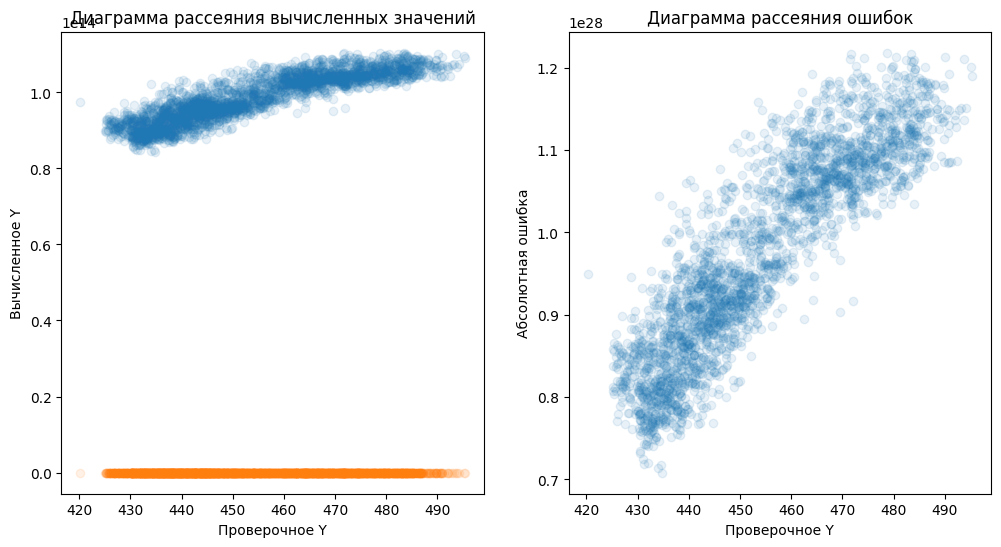

In [470]:
# 4. Построим графики для оценки ошибки
PLOT34(y_test, y_pred)

In [471]:
# 5. Получим численные оценки ошибки:
sgd_no_std_metrics = GET_METRICS_SINGLE(y_test, y_pred)
PRINT_METRICS(sgd_no_std_metrics)

MAE - средняя абсолютная ошибка: 98,455,904,816,713.641
RMSE - кв. корень из среднеквадратичной ошибки: 98,644,942,202,858.547
R2 - коэфф. детерминации:        -33,470,604,688,141,681,304,797,184.000


## Модель SGDRegressor. Обучение на стандартизованных данных

In [472]:
# 1. Создаем объект класса с той же моделью стохастического градиентного спуска
sgd_reg_std =   linear_model.SGDRegressor(
    max_iter        = 10000,    # Тоже значение числа итераций
    tol             = 1e-3,     # Тоже значение сходимости
    random_state    = 8,        # Тоже значение сида
)

# 2. Обучаем модель (подбераем/подогоняем параметры модели) на СТАНДАРТИЗИРОВАНОМ проверочном наборе
sgd_reg_std.fit(xStd_train, yStd_train)

# 3. Получаем вычисленные(predicted) значения на СТАНДАРТИЗИРОВАНОМ проверочном наборе
yStd_pred = sgd_reg_std.predict(xStd_test)
print("Размер вычисленных данных:", len(yStd_pred))
print("Вычисленные данные:")
yStd_pred

Размер вычисленных данных: 2813
Вычисленные данные:


array([-0.57961454,  0.9519273 ,  0.39940942, ..., -1.16499744,
       -0.78171512, -1.15287645])

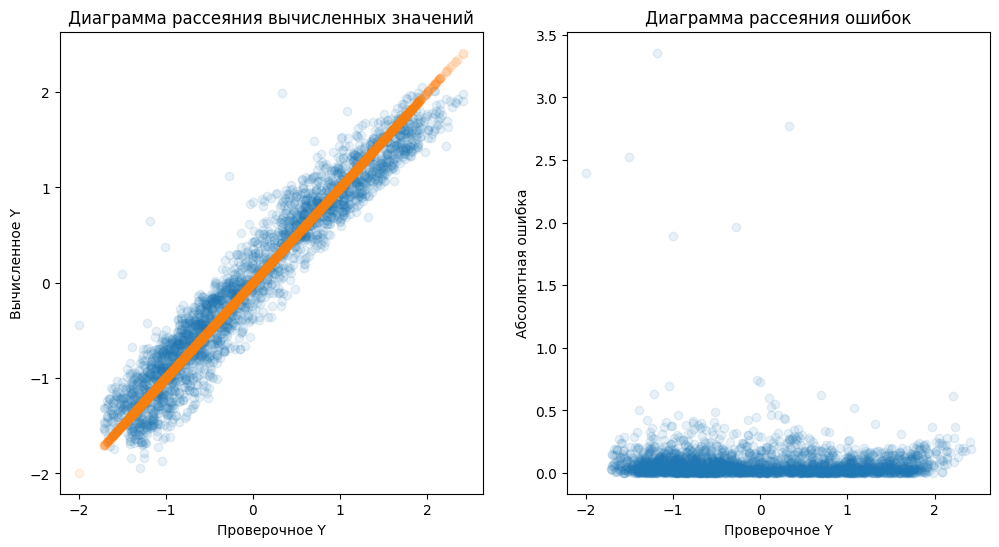

In [473]:
# 4. Построим графики для оценки ошибки
PLOT34(yStd_test, yStd_pred)

In [474]:
# 5. Получить численные оценки ошибки
sgd_std_metrics = GET_METRICS_SINGLE(yStd_test, yStd_pred)
PRINT_METRICS(sgd_std_metrics)

MAE - средняя абсолютная ошибка:   0.213
RMSE - кв. корень из среднеквадратичной ошибки:   0.265
R2 - коэфф. детерминации:          0.930


## Заключение по полученых результатам
Исходя из полученных результатов качества обучения линейной модели на двух наборах  
данных: стандартизованном и не стандартизованном, можно сказать определенно, что  
качество обучение на стандартизованных данных гораздо выше, это можно заметить из  
диаграмм рассеяния вычисленных значений относительно тестовых, диаграмм рассеяния  
ошибки вычисления, а также из результатов статистических оценок качества обучения -  
значений MAE, RMSE и R2.  

Так в первом случае полученные оценки имели крайне большие значения - больше 10 порядков,  
что говорит о крайне низкой точности обучения модели на не стандартизированных данных.

Совершенно иной результат мы получили во втором случае, когда предварительно данные были  
стандартизованны, и на основе этих стандартизованных данных были обучена линейная модель.  
В этом случае ошибки имеют относительно небольшое значение, а коэффициент детерминации  
близок к 1.

Таким образом, можно сказать, что перед обучением линейной модели на основе  
метода SGDRegressor - метода стохатического градиентного спуска, данные обязательно  
необходимо нормализовать.

# Кросс-валидация

В виду того, что при разделении на обучающую и проверочные части используется случайный выбор, оценки точности обученой модели будут напрямую зависеть каждого нового случайного распределения образцов. При этом от случая к случаю оценки точности будут изменятся. 

Для полученя более объективной оценки применятеся прием Кросс-валидации (cross-validation) или скользящего контроля — процедура эмпирического оценивания обобщающей способности алгоритмов. 

Обобщающая способность — это способность модели выдавать правильные результаты не только для примеров, участвовавших в процессе обучения, но и для любых новых, проверочных.

Обучающая (Train) часть выборки разделяется на K-частей, для каждой из которых:
 - происходит создание и обучение модели на данных не принадлежащих текущей K-части
 - полученая промежуточная модель получает оценку точности по образцам K-части

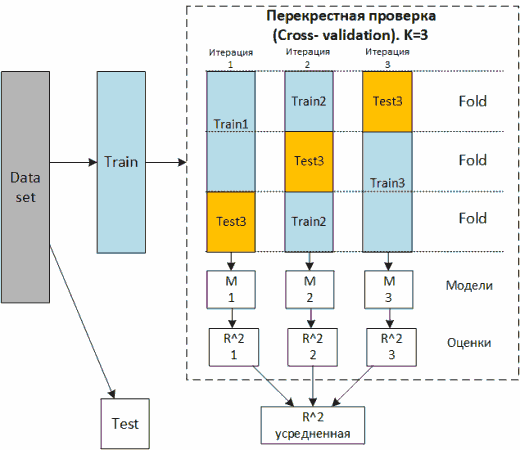



В библиотеке sklearn в пакете sklearn.model_selection присоветуют слудующие функции

- cross_val_score (estimator, X, y, cv, scoring) - получение единственной метрики
- cross_validate  (estimator, X, y, cv, scoring) - получение нескольких метрик
- cross_val_predict(estimator, X, y, cv=3) - получить отклики, вычисленные моделью над набором входных значений

где, scoring - Метрики регрессии имеет режимы:
  - r2 - коэфф. детерминации (R2)
  - neg_mean_squared_error - ср. кв. ошибка (MSE)
  - neg_root_mean_squared_error - кв. корень из ср. кв. ошибки (RMSE)

In [475]:
# Модель, используемая в процессе кросс-валидации:
modelForCV = linear_model.SGDRegressor(
    max_iter        = 10000,
    tol             = 1e-3,
    random_state    = 8,
)

In [476]:
print("MAE. НЕ Стандартизированные  проверочные данные:")
scores_cross = cross_val_score(
    estimator   = modelForCV,   # Модель для обучения (используется при вызове метода .fit())
    X           = x_test,       # Независимые переменные
    y           = y_test,       # Целевая переменная
    cv          = 3,            # Кол-во K-частей (итераций кросс-валидации)
    scoring = 'neg_mean_absolute_error'  # Режим расчитываемой метрики
)

cross_val_sgd_no_std_mse = -scores_cross.mean()

print("Значения метрики по каждому блоку cv:", scores_cross)
print("Усредненное значение метрики:", cross_val_sgd_no_std_mse)

MAE. НЕ Стандартизированные  проверочные данные:
Значения метрики по каждому блоку cv: [-5.66847418e+13 -4.05082340e+14 -3.67245225e+14]
Усредненное значение метрики: 276337435544955.62


In [477]:
print("MAE. Стандартизированные проверочные данные")
scores_cross = cross_val_score(
    estimator   = modelForCV,   # Модель для обучения (используется при вызове метода .fit())
    X           = xStd_test,    # Независимые переменные
    y           = yStd_test,    # Целевая переменная
    cv          = 3,            # Кол-во K-частей (итераций кросс-валидации)
    scoring = 'neg_mean_absolute_error' # Режим расчитываемой метрики
)

cross_val_sgd_std_mse = -scores_cross.mean()

print("Значения метрики по каждому блоку cv:", scores_cross)
print("Усредненное значение метрики:", cross_val_sgd_std_mse)

MAE. Стандартизированные проверочные данные
Значения метрики по каждому блоку cv: [-0.21613646 -0.21430339 -0.2114432 ]
Усредненное значение метрики: 0.2139610181944859


In [478]:
print("RMSE. НЕ Стандартизированные  проверочные данные:")
scores_cross = cross_val_score(
    estimator   = modelForCV,   # Модель для обучения (используется при вызове метода .fit())
    X           = x_test,       # Независимые переменные
    y           = y_test,       # Целевая переменная
    cv          = 3,            # Кол-во K-частей (итераций кросс-валидации)
    scoring = 'neg_root_mean_squared_error'  # Режим расчитываемой метрики
)

cross_val_sgd_no_std_rmse = -scores_cross.mean()

print("Значения метрики по каждому блоку cv:", scores_cross)
print("Усредненное значение метрики:", cross_val_sgd_no_std_rmse)

RMSE. НЕ Стандартизированные  проверочные данные:
Значения метрики по каждому блоку cv: [-5.93474827e+13 -4.05344899e+14 -3.67915268e+14]
Усредненное значение метрики: 277535883222870.0


In [479]:
print("RMSE. Стандартизированные проверочные данные")
scores_cross = cross_val_score(
    estimator   = modelForCV,   # Модель для обучения (используется при вызове метода .fit())
    X           = xStd_test,    # Независимые переменные
    y           = yStd_test,    # Целевая переменная
    cv          = 3,            # Кол-во K-частей (итераций кросс-валидации)
    scoring = 'neg_root_mean_squared_error' # Режим расчитываемой метрики
)

cross_val_sgd_std_rmse = -scores_cross.mean()

print("Значения метрики по каждому блоку cv:", scores_cross)
print("Усредненное значение метрики:", cross_val_sgd_std_rmse)

RMSE. Стандартизированные проверочные данные
Значения метрики по каждому блоку cv: [-0.26632221 -0.26768596 -0.26560956]
Усредненное значение метрики: 0.2665392441547185


In [480]:
print("R2. НЕ Стандартизированные  проверочные данные:")
scores_cross = cross_val_score(
    estimator   = modelForCV,   # Модель для обучения (используется при вызове метода .fit())
    X           = x_test,       # Независимые переменные
    y           = y_test,       # Целевая переменная
    cv          = 3,            # Кол-во K-частей (итераций кросс-валидации)
    scoring = 'r2' # Режим расчитываемой метрики
)

cross_val_sgd_no_std_r2 = scores_cross.mean()

print("Значения метрики по каждому блоку cv:", scores_cross)
print("Усредненное значение метрики:", cross_val_sgd_no_std_r2)

R2. НЕ Стандартизированные  проверочные данные:
Значения метрики по каждому блоку cv: [-1.20267477e+25 -5.54136846e+26 -4.79246208e+26]
Усредненное значение метрики: -3.48469933789952e+26


In [481]:
print("R2. Стандартизированные проверочные данные")
scores_cross = cross_val_score(
    estimator   = modelForCV,   # Модель для обучения (используется при вызове метода .fit())
    X           = xStd_test,    # Независимые переменные
    y           = yStd_test,    # Целевая переменная
    cv          = 3,            # Кол-во K-частей (итераций кросс-валидации)
    scoring = 'r2' # Режим расчитываемой метрики
)

cross_val_sgd_std_r2 = scores_cross.mean()

print("Значения метрики по каждому блоку cv:", scores_cross)
print("Усредненное значение метрики:", cross_val_sgd_std_r2)

R2. Стандартизированные проверочные данные
Значения метрики по каждому блоку cv: [0.92971872 0.9298706  0.92751773]
Усредненное значение метрики: 0.9290356840477373


# Итоговые, сводные результаты и выводы.

Таким образом в ходе выполнения работы были получены следующие показатели качества  
обучения линейной модели на основе метода стохатического градиентного спуска (SGD):

In [482]:
print("Статические характеристики качества обученной модели по методу SGD БЕЗ стандартизации:")
PRINT_METRICS(sgd_no_std_metrics)
print()
print("Статические характеристики качества обученной модели по методу SGD С стандартизацией:")
PRINT_METRICS(sgd_std_metrics)
print()
print("Статические характеристики качества обученной модели с использованием кросс-валидации и метода SGD БЕЗ стандартизации:")
PRINT_METRICS((cross_val_sgd_no_std_mse, cross_val_sgd_no_std_rmse, cross_val_sgd_no_std_r2))
print()
print("Статические характеристики качества обученной модели с использованием кросс-валидации и метода SGD С стандартизации:")
PRINT_METRICS((cross_val_sgd_std_mse, cross_val_sgd_std_rmse, cross_val_sgd_std_r2))

Статические характеристики качества обученной модели по методу SGD БЕЗ стандартизации:
MAE - средняя абсолютная ошибка: 98,455,904,816,713.641
RMSE - кв. корень из среднеквадратичной ошибки: 98,644,942,202,858.547
R2 - коэфф. детерминации:        -33,470,604,688,141,681,304,797,184.000

Статические характеристики качества обученной модели по методу SGD С стандартизацией:
MAE - средняя абсолютная ошибка:   0.213
RMSE - кв. корень из среднеквадратичной ошибки:   0.265
R2 - коэфф. детерминации:          0.930

Статические характеристики качества обученной модели с использованием кросс-валидации и метода SGD БЕЗ стандартизации:
MAE - средняя абсолютная ошибка: 276,337,435,544,955.625
RMSE - кв. корень из среднеквадратичной ошибки: 277,535,883,222,870.000
R2 - коэфф. детерминации:        -348,469,933,789,951,994,024,165,376.000

Статические характеристики качества обученной модели с использованием кросс-валидации и метода SGD С стандартизации:
MAE - средняя абсолютная ошибка:   0.214
RMSE -

Исходя из полученных в ходе выполнения данной работы результатов, можно сказать, что  
перед построением некоторых видов линейных регрессионных моделей, в частности,  
основанных на методе стохатического градиентного спуска, необходимо проводить  
процедуру стандартизации данных, т.н. приведение их к такому виду, когда среднее значение  
характеристик будет равно нулю, а дисперсия равна 1. В ином случае, т.н. если не проводить  
процедуру стандартизации, то построеные модели будут иметь крайне низкую точность, что,  
вероятно, связано с накоплением арифметической ошибки в процессе вычисления коэффициентов на  
основе этих не стандартизованных данных.  

Так в нашем случае при отсутствие предварительной стандартизации данных, построенные  
модели имеют среднюю абсолютную ошибку, превыщающую 10 порядков! Аналогичные результаты  
получаются и для других показателей качества модели.

Если же проводить сравнение полученных результатов качества моделей с использованием и  
не использованием кросс-валидации, то можно заметить, что полученные показатели  
получились примерно одинаковыми, что говорит о том, что исходный набор данных, в целом, однороден,  
иными словами, в нашем случае нет таких наборов данных, которые кардинально не согласовывались бы с общей построенной зависимостью между целевой и независимыми переменными в данной модели. Это также подтверждается вычисленными метриками качества для каждой из подмоделей в кросс-валидации - они также приблизительно одинаковы между собой.

## Список литературы и доп. материалы:


Список материалов:

1. [Рус] Дьяконов А. Ансамбли в машинном обучении. URL:
https://dyakonov.org/2019/04/19/%D0%B0%D0%BD%D1%81%D0%B0%D0%BC%D0%B1%D0%BB%D0%B8-%D0%B2-%D0%BC%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%BC-%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B8/

2. Scikit-learn. стохастический градиентный спуск  

  2.1. [Eng] Scikit-learn. Класс стохастического градиентного спуска. URL: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html  

  2.2. [Eng] Scikit-learn. Класс стохастического градиентного спуска. URL: https://scikit-learn.org/stable/modules/sgd.html#regression  

3. Стандартизация  

  3.1. [Eng] Scikit-learn. Стандартизация. URL: https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling

  3.2. [Eng] Scikit-learn. Сравнение влияния различных шкал на данные в выбросами. URL: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html


4. [Рус] Мюллер А., Гвидо С. Введение в машинное обучение с помощью Python //Руководство для специалистов по работе с данными. СПб.: ООО «Альфа-книга. – 2017. –  с. 269 (Перекрестная проверка)